# Задание

Рассмотреть варианты Байесовского классификатора, представленные в sklearn и найти тот, что будет лучше всего (равномерно) предсказывать все классы по тексту (`./data/financial-news-sentiment.xlsx`).
* Нужно построить распараллеленный препроцессинг на основе Wordnet lematizer.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2

In [42]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm import tqdm # для отслеживания прогресса

import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)

import re # для регулярных выражений
import nltk # для работы с текстом
from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки

from sklearn.feature_extraction.text import TfidfVectorizer # векторизатор текста
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [43]:
DATA_DIR = "./data/" # путь до папки с данными
RANDOM_STATE = 42 # число для задания случайности
CLEANING_VARS = ["none", "trash", "stop_words", "punctuation", "digits", "all"] # варианты очистки текста
ADD_STOP_WORDS = ["ca", "n't", "'s"] # дополнительные стоп-слова

MIN_DF = 5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов меньше заданной пропорции (int — абсолютное значение)
MAX_DF = 0.5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов больше заданной пропорции (int — абсолютное значение)
MAX_FEATURES = 15000 # максимальное число фичей (токенов) в словаре векторизатора

TEST_SIZE = 0.2 # размер тестовой выборки

In [65]:
# nltk.download('wordnet') # загрузка дополнительных пакетов для nltk
# nltk.download('punkt') # загрузка дополнительных пакетов для nltk

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных топоков

Количество доступных потоков:  4


# Предобработка датасета

In [28]:
dataset = pd.read_excel(DATA_DIR + "financial-news-sentiment.xlsx", usecols=[0,1]) # считывание excel данных (usecols=[0,1] — только первые две колонки)
dataset

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish
...,...,...
12419,Stocks making the biggest moves midday: TD Ame...,Neutral
12420,Stocks making the biggest moves premarket: Fit...,Neutral
12421,Stocks making the biggest moves premarket: Hom...,Neutral
12422,Stocks making the biggest moves premarket: TD ...,Neutral


## Избавляемся от пропущенных данных

In [29]:
dataset = dataset[dataset["text"].notnull()] # оставляем те строки, у которых столбец "text" имеет значение
dataset = dataset[dataset["label"].notnull()] # оставляем те строки, у которых столбец "label" имеет значение

In [30]:
dataset.shape # размер датасета после удаления пропусков

(11934, 2)

## Избавляемся от выбросов

In [31]:
dataset["label"].value_counts()

label
Neutral                                                                                7732
Bullish                                                                                2397
Bearish                                                                                1788
 answered by @Jess_Shankleman https://t.co/V7NeutralzSgbNnc"                              1
 well                                                                                     1
 in all likelihood                                                                        1
 theyвЂ™re finallyвЂ¦ https://t.co/sVmzdrN4ho"                                            1
Bullish3Bullish.98 points                                                                 1
 breaking 7 consecutive up weeksвЂ¦ https://t.co/kBearish4JSxx56R"                        1
 the #NasdaqFam is setting the pace andвЂ¦ https://t.co/hFU6Y6EUBullisht"                 1
 celebrate 'Drygiving' with these non-boozy alternatives.                 

In [32]:
dataset = dataset[dataset["label"].isin(["Neutral", "Bullish", "Bearish"])] # оставляем те строки, у которых столбец "label" имеет допустимое значение
dataset.shape # размер датасета после удаления выбросов

(11917, 2)

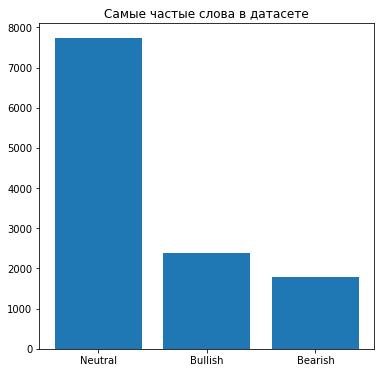

In [33]:
plt.figure(figsize=(6,6)) # задание размера графика
plt.bar(dataset["label"].value_counts().index, dataset["label"].value_counts()) # построение столбатой диаграммы по данным (dataset["label"].value_counts().index — колонки, dataset["label"].value_counts() — их значения)
plt.title("Самые частые слова в датасете") # название графика
plt.show() # вывод графика

В данных наблюдается дисбаланс по классам, его решать будем с помощью метода "upsampling" на этапе векторизации (генерировать дополнительные данные для малопредставленных классов).

##

In [34]:
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)

## Очистка датасета

In [35]:
stop_words = stopwords.words('english') # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [46]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[]) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re
    # import pymorphy3
    from nltk.tokenize import word_tokenize
    # from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns:
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            # df[column] = df[column].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
            # df[column] = df[column].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

            # df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)

            # df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы

            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

        # df = df[df[column].notnull()] # оставляем те строки, у которых рассматриваемый столбец имеет значение
        df = df[df[column] != ""] # оставляем те строки, данные в которых не занулились

    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)
    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, ["text"], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

После очистки ещё несколько строк были удалены из датасета, так как они сократились до пустой строки.

## Отображение самых частых слов в датасете

Помогает определить дополнительные стоп-слова.

In [3]:
dataset_cleared = pd.read_csv(DATA_DIR + "data_all.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных
dataset_cleared

,text,label
0,bynd jpmorgan reel expectation beyond meat,Bearish
1,ccl rcl nomura point booking weakness carnival...,Bearish
2,cx cemex cut credit suisse jp morgan weak buil...,Bearish
3,es btig research cut neutral,Bearish
4,fnko funko slide piper jaffray pt cut,Bearish
...,...,...
11820,stock making biggest move midday td ameritrade...,Neutral
11821,stock making biggest move premarket fitbit xer...,Neutral
11822,stock making biggest move premarket home depot...,Neutral
11823,stock making biggest move premarket td ameritr...,Neutral


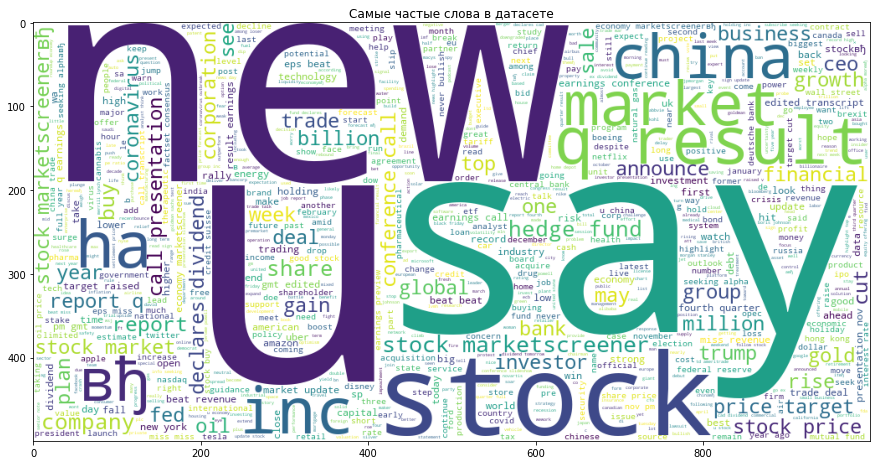

In [51]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset_cleared["text"])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера графика
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете")
plt.show() # вывод графика

# Обучение моделей

## Векторизация

In [44]:
data = {} # словарь под все варианты обработки вида
# {"var 1":
#   {
#     "X_train": [...],
#     "X_test": [...],
#     "y_train": [...],
#     "y_test": [...],
#     "vectorizer": векторизатор
#   }, ...
# }

In [50]:
for var in CLEANING_VARS: # идём по вариантам обработки
    dataset_cleared = pd.read_csv(f"{DATA_DIR}data_{var}.csv",  sep=";", encoding="utf8", index_col=False) # считывание данных об очищенном датасете

    vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=MIN_DF, max_df=MAX_DF, max_features=MAX_FEATURES) # векторизатор (с ограничениями на построение vocabulary, чтобы вектора были не слишком большие)
    data_X = vectorizer.fit_transform(dataset_cleared["text"]).toarray() # конвертируем документы (текста) в вектора
    print(f"Размерность при варианте обработки '{var}' до: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")

    # factorizer = pd.factorize(dataset_cleared["label"]) # перевод строковых таргетов (type: object) в числовой формат (type: int, от 1...)
    # data_y = factorizer[0] # таргеты (уже в числовом формате, под индексом 1 — их названия)
    data_y = dataset_cleared["label"].to_numpy() # берём таргеты (не переводя их в числовой формат)

    max_samples = dataset_cleared["label"].value_counts()[0] # число элементов в наиболее представленном классе
    max_label = dataset_cleared["label"].value_counts().index[0] # название наиболее представленного класса

    # сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (upsampling) 
    data_distribution = {} # словарь под распределение данных по классам
    for label_value in dataset_cleared["label"].unique(): # идём по уникальным таргетам
        data_distribution[label_value] = data_X[data_y == label_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому label_value
        
        print(f"    В классе '{label_value}' было {len(data_distribution[label_value])} записей.")

    # после процедуры upsampling, собираем данные обратно в датасет
    print(f"---------------------------------------------------------------------------")
    data_resampled = pd.DataFrame(columns=[*range(data_X.shape[1]), "label"]) # заготовка под DataFrame без дисбаланса классов (слолбцы: data_X.shape[1] фич и "label")
    for label_value in dataset_cleared["label"].unique(): # идём по уникальным таргетам
        data_distribution[label_value] = resample(data_distribution[label_value], n_samples=max_samples, random_state=RANDOM_STATE) # добавляем записи к рассматриваемому таргету до n_samples по соответствующему распределению
        print(f"    В классе '{label_value}' стало {len(data_distribution[label_value])} записей.")

        data_for_label = pd.DataFrame(data_distribution[label_value]) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
        data_for_label["label"] = label_value # добавляем колонку таргета в DataFrame (у всех строк будет значение рассматриваемого таргета)

        data_resampled = pd.concat([data_resampled, data_for_label]) # соединяем вместе все DataFrame_ы классов

    data_y = data_resampled["label"].values # запоминаем таргеты (array)
    del data_resampled["label"] # в data_resampled (DataFrame) оставляем только вектора фич
    data_X = data_resampled.values # возвращаем фичи к типу array (хоть можно было оставить и DataFrame)

    print(f"Размерность при варианте обработки '{var}' после: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")
    print(f"===========================================================================")

    data[var] = {} # заготовка под сплит
    data[var]["X_train"], data[var]["X_test"], data[var]["y_train"], data[var]["y_test"] = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y)
    # разбиваем датасет (dataset["source_text"] — данные, dataset["ethno"] — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках
    data[var]["vectorizer"] = vectorizer # векторизатор

Размерность при варианте обработки 'none' до: сэмплов — 11917, фич — 3276.
    В классе 'Bearish' было 1788 записей.
    В классе 'Bullish' было 2397 записей.
    В классе 'Neutral' было 7732 записей.
---------------------------------------------------------------------------
    В классе 'Bearish' стало 7732 записей.
    В классе 'Bullish' стало 7732 записей.
    В классе 'Neutral' стало 7732 записей.
Размерность при варианте обработки 'none' после: сэмплов — 23196, фич — 3276.
Размерность при варианте обработки 'trash' до: сэмплов — 11826, фич — 3272.
    В классе 'Bearish' было 1782 записей.
    В классе 'Bullish' было 2361 записей.
    В классе 'Neutral' было 7683 записей.
---------------------------------------------------------------------------
    В классе 'Bearish' стало 7683 записей.
    В классе 'Bullish' стало 7683 записей.
    В классе 'Neutral' стало 7683 записей.
Размерность при варианте обработки 'trash' после: сэмплов — 23049, фич — 3272.
Размерность при варианте обраб

## 1) GaussianNB

## 2) MultinomialNB

## 3) BernoulliNB

## 4) ComplementNB

# Выводы